# Imports

In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.models import Model
import tensorflow_model_remediation as tfmr
import sklearn
from tensorflow.keras import layers, losses, metrics
from keras.layers import Input, Dense, UpSampling1D, Conv1D, AveragePooling1D, MaxPooling1D, Flatten, Reshape, Dropout, Conv1DTranspose, ZeroPadding1D, Cropping1D, Conv1DTranspose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from time import time
import scipy as sp
from tqdm import tqdm
import os
import multiprocessing
import subprocess
from tensorflow.keras.utils import plot_model

2023-03-08 14:51:54.612696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 14:51:54.684898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 14:51:54.684912: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 14:51:55.193550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# Restrict TensorFlow for a certain amount of gpu memory
gpu_memory_limit = 1024*12 # 12 GB
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=gpu_memory_limit)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    print("Successfully set GPU memory limit to", gpu_memory_limit, "MB")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
  else : 
    print("No GPU found")


2023-03-08 14:51:56.484117: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 14:51:56.484130: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 14:51:56.484141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (home): /proc/driver/nvidia/version does not exist


# Read in data 

In [3]:
df_raw_signal = pd.read_csv("Testdata/CleanedSignal/modified_data.txt", sep=" ")
df_raw_signal.columns = ["Signal"]
#drop index column
df_raw_signal.head()

print(df_raw_signal.shape)

(200154555, 1)


In [4]:
#Information about the dataset
sampling_rate = 20000
regular_stimuli_interval = 8 #seconds 

# Normalize signal

In [5]:
#normalize to range [0, 1]. We use this range because the sigmoid activation function is used in the output layer 

#How the normalization works:
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min
#where min, max = feature_range.
data_scaler = MinMaxScaler(feature_range=(0, 1))
df_raw_signal["Signal normalized"] = data_scaler.fit_transform(df_raw_signal["Signal"].values.reshape(-1, 1))

df_raw_signal.head(5)

,Signal,Signal normalized
0,-98.6,0.495077
1,-79.0,0.496057
2,-85.4,0.495737
3,-36.6,0.498177
4,-29.6,0.498527


# Train Test Split


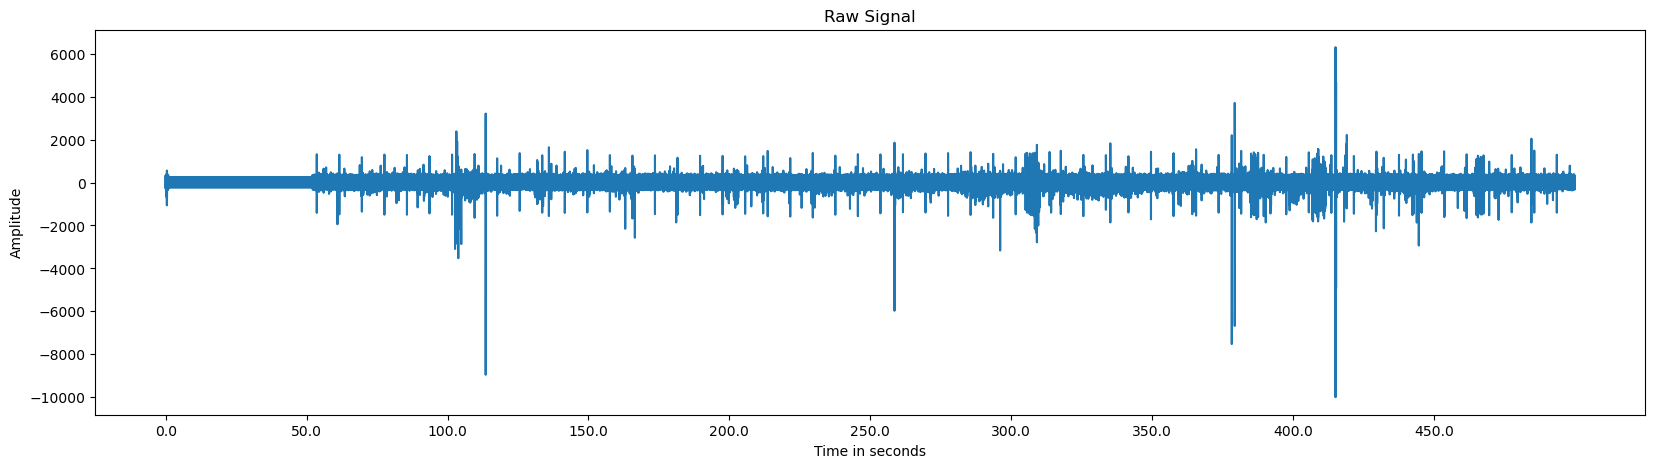

In [6]:

plt.figure(figsize=(20, 5))

offset = 0
figure_width = 10000000
num_xticks = 10

plt.plot(df_raw_signal["Signal"][offset:figure_width+offset])
plt.title("Raw Signal")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude")
plt.xticks(np.arange(0, figure_width, figure_width//num_xticks), np.arange(int(offset), int(figure_width + offset), int(figure_width/num_xticks))/sampling_rate)

plt.show()


In [7]:
neural_network_width = 1024 #width of the used neural network, a power of 2 is helpful as we use stride 2 in the convolutional layers (half the width of the input)

#split df_raw_signal into chunks of width as defined before
df_raw_signal_split = [df_raw_signal[i:i+neural_network_width] for i in range(0,df_raw_signal.shape[0],neural_network_width)]

#Drop the last one if its too small 
if(len(df_raw_signal_split[-1]) < neural_network_width) : 
    df_raw_signal_split.pop()

#convert the data to numpy array
data = np.array([df_raw_signal_split[i]["Signal normalized"].values for i in range(len(df_raw_signal_split))])

test_size = 0.2 #80% training data, 20% test data, we cant use train_test_split because we dont want any shuffling

x_train = data[:int(data.shape[0]*(1-test_size))]
test_data = data[int(data.shape[0]*(1-test_size)):]

#shuffle the train data for better training generalization
np.random.seed(1)
np.random.shuffle(x_train)

print("Amount of training samples: ", x_train.shape[0])
print("Amount of test samples: ", test_data.shape[0])

Amount of training samples:  156370
Amount of test samples:  39093


# Visualization

# The actual convolutional autoencoder

In [8]:
#reshape such that we have one extra dimension for the convolutional layer
#this is necessary because the convolutional layer expects a 3D input (batch_size, width, channels)
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
test_data_reshape = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

print(x_train_reshape.shape)
print(test_data_reshape.shape)

(156370, 1024, 1)
(39093, 1024, 1)


# Used Metrics to evaluate the model performance

In [9]:
#peak signal-to-noise ratio
def psnr(y_true : tf.Tensor, y_pred : tf.Tensor) :      
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

#signal-to-noise ratio
def snr(y_true : tf.Tensor, y_pred : tf.Tensor) : 
    inner_mse = tf.reduce_mean(tf.square(y_true - y_pred))
    inner_var = tf.math.reduce_variance(y_true)
    inner = 10 * (tf.math.log(inner_var / inner_mse) / tf.math.log(10.0))
    return tf.reduce_mean(inner)

#percent root-mean-square difference
def prd(y_true : tf.Tensor, y_pred : tf.Tensor) : 
    inner = tf.divide(tf.reduce_mean(tf.square(y_true - y_pred)), tf.reduce_mean(tf.square(y_true)))
    return 100 * tf.sqrt(inner)

#cross correlation -> does not work with high spikes TODO
def cc(y_true : tf.Tensor, y_pred : tf.Tensor) : 
    var_true = tf.math.reduce_variance(y_true)
    var_pred = tf.math.reduce_variance(y_pred)
    covariance = tf.math.reduce_mean((y_true - tf.math.reduce_mean(y_true)) * (y_pred - tf.math.reduce_mean(y_pred)))
    return covariance / tf.sqrt(var_pred * var_true)

def get_compression_rate(init_shape : tuple, latent_shape : tuple) : 
    return (init_shape[1] * init_shape[2]) / (latent_shape[1] * latent_shape[2])

def get_quality_score(init_shape : tuple, latent_shape : tuple, y_true : tf.Tensor, y_pred : tf.Tensor) : 
    return get_compression_rate(init_shape, latent_shape) * (1 - prd(y_true, y_pred))

# Definition of the actual model

In [10]:
assert(x_train_reshape.shape[1] == neural_network_width)

encoder_seq = Sequential([
    Input(shape=(neural_network_width,1), name="Encoder_Input"),
    Conv1D(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Encoder_layer_1"),
    Conv1D(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Encoder_layer_2"),
    Conv1D(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Encoder_layer_3"),
    Conv1D(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Encoder_layer_4"),
    Conv1D(filters=8, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Encoder_layer_5"),
    Conv1D(filters=4, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Encoder_layer_6"),
    Conv1D(filters=1, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Encoder_layer_7"),
], name="Encoder")

decoder_seq = Sequential([
    Input(shape=(encoder_seq.output.shape[1], encoder_seq.output.shape[2]), name="Decoder_Input"),
    Conv1DTranspose(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Decoder_layer_1"),
    Conv1DTranspose(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Decoder_layer_2"),
    Conv1DTranspose(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Decoder_layer_3"),
    Conv1DTranspose(filters=16, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Decoder_layer_4"),
    Conv1DTranspose(filters=8, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Decoder_layer_5"),
    Conv1DTranspose(filters=4, kernel_size=8, strides=2, activation='leaky_relu',  padding='same', name="Decoder_layer_6"),
    Conv1DTranspose(filters=1, kernel_size=8, strides=2, activation='sigmoid',  padding='same', name="Decoder_layer_7"),
], name="Decoder")

autoencoder = Sequential([
    encoder_seq,
    decoder_seq
], name="CAE_128")


print("Compression rate: ", get_compression_rate(encoder_seq.input.shape, encoder_seq.output.shape))

#optimize using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=[snr, psnr, prd, cc])
autoencoder.build(x_train_reshape.shape)
autoencoder.summary()

2023-03-08 14:52:17.038509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compression rate:  128.0
Model: "CAE_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 8, 1)              7661      
                                                                 
 Decoder (Sequential)        (None, 1024, 1)           7661      
                                                                 
Total params: 15,322
Trainable params: 15,322
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Store the layout of the model to a png file
def store_model(model, to_file='model.png'):
    path = os.path.join(os.getcwd(), to_file)
    print("Saving model to: ", path)
    plot_model(model, to_file=path, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, show_dtype=False)

store_model(autoencoder, to_file='Models/CR_128.png')

Saving model to:  /home/philip/Code/ConvAutoencoder/Models/CR_128.png


# Helper Methods

In [12]:
#TODO: Change the x-axis of the plots to time in seconds, not in samples
#TODO: Add a legend to the plots
#TODO: Add a title to the plots and name the axis

#encode and decode the test data
def process_data(encoder, decoder, base_data = test_data_reshape) :
    print("Encoding: ")
    encoded = encoder.predict(base_data, verbose=1)
    print("Decoding: ")
    decoded = decoder.predict(encoded, verbose=1)
    return encoded, decoded

#visualize the raw/encoded/decoded data of the test data with width of the neural network (neural_network_width)
#offset to not always show the same data
def vis(encoded, decoded, save=False, name="", offset=0) : 
    plt.figure(figsize=(20,5))
    plt.suptitle(("Test Data for CR 64"))
    x1 = plt.subplot(1,3,1)
    x1.plot(test_data_reshape[offset])
    x1.set_title("Input of Encoder")
    x2 = plt.subplot(1,3,2)
    x2.plot(encoded[offset])
    x2.set_title("Output of Encoder")
    x3 = plt.subplot(1,3,3)
    x3.plot(decoded[offset])
    x3.set_title("Output of Decoder")
    x1.set_ylim(0.3,0.7)
    #limit the encoded data accordingly as it might not be in the range of 0-1
    x2_lims = x2.get_ylim()
    x2.set_ylim(min(x2_lims[0],0),max(x2_lims[1],1))
    x3.set_ylim(0.3,0.7)
    x1.set_xlabel("Data Points")
    x2.set_xlabel("Data Points")
    x3.set_xlabel("Data Points")
    x1.set_ylabel("Signal Strength")
    x2.set_ylabel("Signal Strength")
    x3.set_ylabel("Signal Strength")
    if save :
        plt.savefig(name + ".png")
        plt.close()
    else :
        plt.show()


#visualize the raw/encoded/decoded data of the test data with width width of a full stimuli interval (regular_stimuli_interval * sampling_rate)
#offset to not always show the same data
def vis_full(encoded, decoded, save=False, name="", offset=0): 
    plt.figure(figsize=(20,5))
    x1 = plt.subplot(1,3,1)
    appended_orig = tf.concat([test_data_reshape[i+offset] for i in range(int((regular_stimuli_interval * sampling_rate) / neural_network_width))], axis=0)
    x1.plot(appended_orig)
    x1.set_title("Original")
    x2 = plt.subplot(1,3,2)
    appended_encoded = tf.concat([encoded[i+offset] for i in range(int((regular_stimuli_interval * sampling_rate) / neural_network_width))], axis=0)
    x2.plot(appended_encoded)
    x2.set_title("Encoded")
    x3 = plt.subplot(1,3,3)
    appended_decoded = tf.concat([decoded[i+offset] for i in range(int((regular_stimuli_interval * sampling_rate) / neural_network_width))], axis=0)
    x3.plot(appended_decoded)
    x3.set_title("Decoded")
    x1.set_ylim(0,1)
    #limit the encoded data accordingly as it might not be in the range of 0-1
    x2_lims = x2.get_ylim()
    x2.set_ylim(min(x2_lims[0],0),max(x2_lims[1],1))
    x3.set_ylim(0,1)
    figure_width = len(appended_orig)
    if save :
        plt.savefig(name + ".png")
        plt.close()
    else : 
        plt.show()

#Save the model and some visualizations
def save_model(name : str , model : Model) : 
    base_path = "/ConvAutoencoder/Models"
    if not os.path.exists(base_path) :
        os.mkdir(base_path)
    os.chdir(base_path)
    model.save_weights(name + ".h5")
    model.evaluate(test_data_reshape, test_data_reshape)
    encoded, decoded = process_data(autoencoder.layers[0], autoencoder.layers[1])
    for i in range(5) :
        vis(encoded, decoded, save=False, name=name + "_" + str(i), offset=i)
    for i in range(5) : 
        rand = np.random.randint(0, test_data_reshape.shape[0])
        vis_full(encoded, decoded, offset=rand, save=False, name=name + "_full_" + str(i))
    print("Saved model to disk")
    os.chdir("/")
   

#Train the model if it does not exist yet, otherwise load it
#Returns the individual encoder and decoder models
#The two sub-models are trained in the autoencoder but can be used separately
def train(name: str) : 
    #check if path exists in the Models folder 
    if not os.path.exists("Models/" + name + ".h5") :
        #Model does not exist yet, train it
        autoencoder.fit(x_train_reshape, x_train_reshape, epochs=100, batch_size=128, validation_data=(test_data_reshape, test_data_reshape))
        #Save the model
        #save_model(name, autoencoder)
    else : 
        #Model exists, load it 
        #The model has to be compiled before it can be loaded
        #The stored autoencoder must have the same structure as the one defined above i.e. the same number of layers and the same number of neurons in each layer etc.
        autoencoder.load_weights("Models/" + name + ".h5")        
        print("Loaded model from disk")
        
    #Evaluate the complete model
    autoencoder.evaluate(test_data_reshape, test_data_reshape)
    encoder = autoencoder.layers[0]
    decoder = autoencoder.layers[1]
    return encoder, decoder

In [13]:
encoder, decoder = train("No_Pool_CR_128")
assert(decoder.output.shape[1] == x_train_reshape.shape[1] and decoder.output.shape[2] == x_train_reshape.shape[2]) #Sanity check that the decoder output has the same shape as the input
#get the encoded and decoded data for the test data
encoded, decoded = process_data(encoder, decoder)

Loaded model from disk
1222/1222 [==============================] - 3s 2ms/step - loss: 3.6111e-05 - snr: -1.2170e-04 - psnr: 44.9911 - prd: 1.1526 - cc: 4.2639e-04
Encoding: 
1222/1222 [==============================] - 1s 884us/step
Decoding: 
1222/1222 [==============================] - 2s 2ms/step


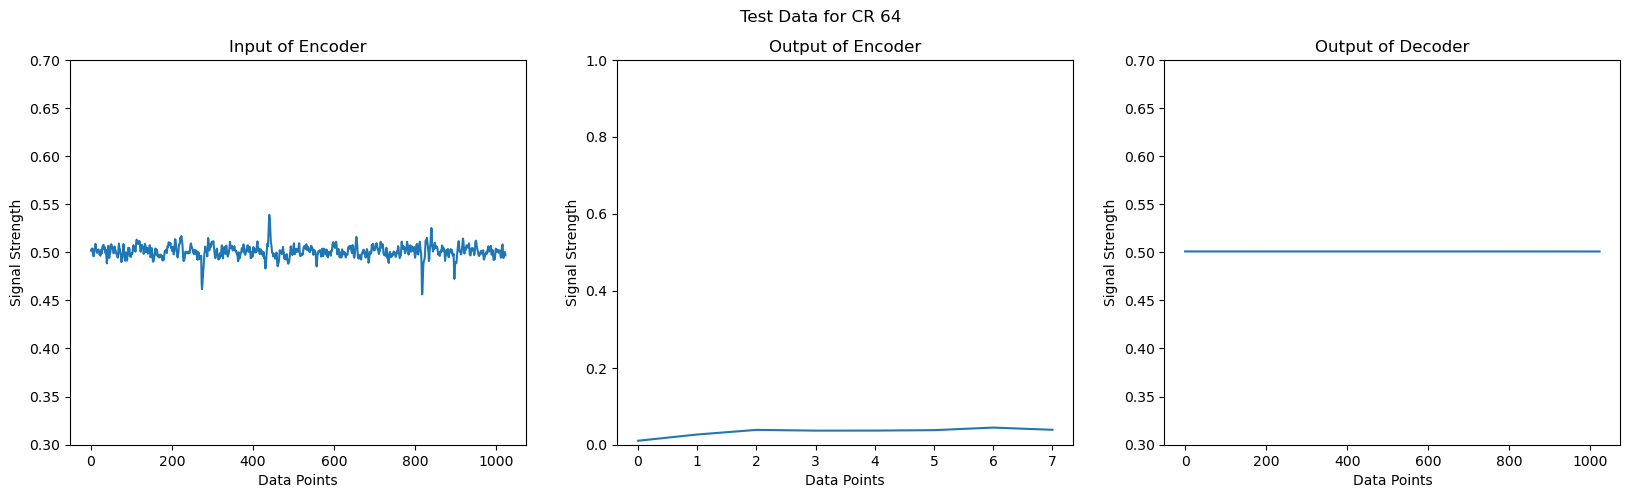

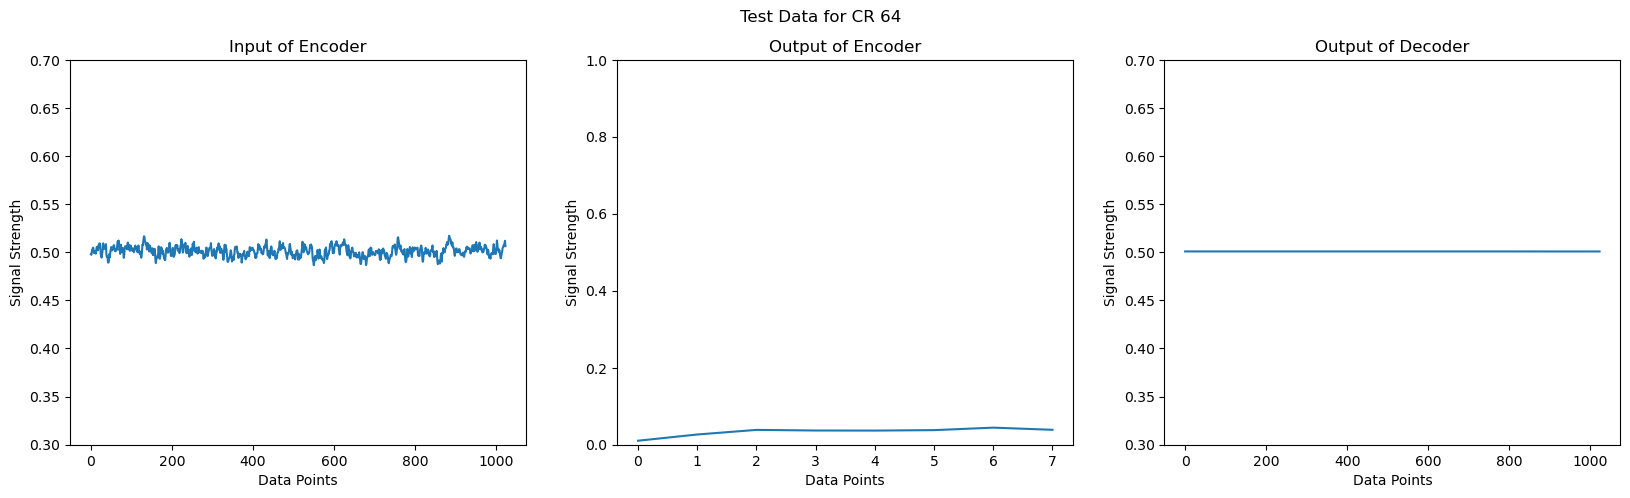

In [14]:
#for i in range(2) : 
#    rand = np.random.randint(0, test_data_reshape.shape[0])
#    vis_full(encoded, decoded, offset=rand)
#
for i in range(2) : 
    rand = np.random.randint(0, test_data_reshape.shape[0])
    vis(encoded, decoded, offset=rand)

# Spike counting

We count the number of times the signal crosses a given threshold. Further the position of the crossing is saved.
This is done for the (normalized) raw signal and the reconstructed signal.

#How the thresholds work
As the signal is normalized to a range the threshholds also must be between 0 and 1. The thresholds are given as an absolute value.


The spike counting is done in parallel by spliting the into segments of 1000 points and then processing them in parallel (on every core of the CPU).
The results are then merged.

In [15]:
def get_intersection(x1, y1, x2, y2, threshold) :
        if x1 == x2:
            return x1
        b = (x1*y2 - y1*x2)/(x1-x2)
        if(x1 == 0) : 
            return (threshold-b)/y1
        return (threshold-b)/((y1-b)/x1)

#count the amount of times the signal passes a certain threshold given as an absolute value between 0 and 1
def count_spikes(signal, starting_point, thresholds: list) -> dict : 
    threshholds = sorted(thresholds)
    #sanity check
    for threshold in thresholds :
        if threshold < 0 or threshold > 1 : 
            raise ValueError("Thresholds must be between 0 and 1")

    #Initialize the data structures
    all_spike_data = dict()
    is_across : dict = dict()
    for threshold in thresholds :
        all_spike_data[threshold] = (0,[])
        is_across[threshold] = signal[0] >= threshold
        
    #Iterate over the given signal points and check if the signal crosses a threshold
    #If yes then add the intersection point to the list of spike times
    for i in range(len(signal)) :
        for threshold in thresholds :
            if signal[i] >= threshold and not is_across[threshold] :
                all_spike_data[threshold] = (all_spike_data[threshold][0] + 1, all_spike_data[threshold][1] + [starting_point + get_intersection(i-1, signal[i-1], i, signal[i], threshold)])
                is_across[threshold] = True
            elif signal[i] <= threshold and is_across[threshold] :
                is_across[threshold] = False
                all_spike_data[threshold] = (all_spike_data[threshold][0] + 1, all_spike_data[threshold][1] + [starting_point + get_intersection(i-1, signal[i-1], i, signal[i], threshold)])


    #remove nan values
    for threshold in thresholds :
        all_spike_data[threshold] = (all_spike_data[threshold][0], [x for x in all_spike_data[threshold][1] if not np.math.isnan(x)])

    return all_spike_data

def count_spikes_parallel(signal, threshholds : list) : 
    number_intervals = multiprocessing.cpu_count()

    #split the signal into the number of available cores with the respective starting point
    signal_split = []
    for i in range(number_intervals) :
        signal_split.append((signal[int(i*len(signal)/number_intervals):int((i+1)*len(signal)/number_intervals)], int(i*len(signal)/number_intervals), threshholds))
    

    lengths = [len(x[0]) for x in signal_split]

    assert(sum(lengths) == len(signal))

    #run the count_spikes function on each split
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.starmap(count_spikes, signal_split)

    #merge the results
    all_spike_data = dict()
    for threshold in threshholds :
        all_spike_data[threshold] = (0,[])
    for result in tqdm(results, total=len(results), desc="Merging results") :
        for threshold in threshholds :
            all_spike_data[threshold] = (all_spike_data[threshold][0] + result[threshold][0], all_spike_data[threshold][1] + result[threshold][1])

    return all_spike_data

threshholds_to_check = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
print("Checking thresholds: " + str(threshholds_to_check))
original_data_concat = tf.concat([test_data_reshape[i] for i in range(len(test_data_reshape))], axis=0)
decoded_data_concat = tf.concat([decoded[i] for i in range(len(decoded))], axis=0)
original_data_concat = original_data_concat.numpy().flatten()
decoded_data_concat = decoded_data_concat.numpy().flatten()

assert(len(original_data_concat) == len(decoded_data_concat))


all_spike_data_original = count_spikes_parallel(original_data_concat, threshholds_to_check)
all_spike_data_decoded = count_spikes_parallel(decoded_data_concat, threshholds_to_check) 

Checking thresholds: [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (threshold-b)/((y1-b)/x1)
/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (threshold-b)/((y1-b)/x1)
/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (threshold-b)/((y1-b)/x1)
/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (threshold-b)/((y1-b)/x1)
/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (threshold-b)/((y1-b)/x1)
/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (threshold-b)/((y1-b)/x1)
/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return (threshold-b)/((y1-b)/x1)
/tmp/ipykernel_984030/1166296211.py:7: RuntimeWarning: invalid

In [16]:
def plot_spikes(signal1, signal2, spike_data1, spike_data2, thresholds, start, width, title="",safe=False, save_path="") : 
    for threshold in thresholds :
        plt.figure(figsize=(20,5))

        plt.plot(signal1[start-width:start+width], label="Original Signal", color='b')
        count = 0 
        for spike in spike_data1[threshold][1] :
            if spike > (start-width) and spike < (start+width) :
                count += 1
                plt.axvline(x=spike-(start-width), color='r', linestyle='--', linewidth=0.5)
            

        plt.plot(signal2[start-width:start+width], label="Decoded Signal", color='g')
        for spike in spike_data2[threshold][1] :
            if spike > (start-width) and spike < (start+width) :
                count += 1
                plt.axvline(x=spike-(start-width), color='r', linestyle=':', linewidth=0.5)

        plt.axhline(y=threshold, color='g', linestyle='--', linewidth=0.5, label="Threshold")
        if title != "" : 
            plt.title(title)
        plt.legend()
        if count == 0 : 
            plt.close()
            continue

        if(safe) : 
            #check if the save path exists
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            plt.savefig(save_path + "threshold_" + str(threshold).replace(".","_") + ".png")
        
        plt.show()

#start = 6793294
width = 500
start = int(29333500 -  width/2)
plot_spikes(original_data_concat, decoded_data_concat, all_spike_data_original, all_spike_data_decoded, threshholds_to_check, start, width, safe=False, save_path="ConvAutoencoder/SpikeExamples/CR_128/")

# Evaluate the results

When comparing the raw signal and the reconstructed signal, we can see that the spikes are never exactly at the same position because of the interpolation.
Thus we have to compare the spikes in a certain range around the position of the spike in the raw signal.
We set the range to 1 point, i.e. the spike in the reconstructed signal has to be in the range of the spike in the raw signal +-1 point.
This point is according to the sampling rate, so effictively 1/'sampling rate' seconds. Currently we use a sampling rate of 20000hz, so 1 point is 0.00005  seconds.


In [17]:
#Check how many of the original spikes are at the same position in the decoded data
num_same_spikes = dict()
for threshold in threshholds_to_check :
    num_same_spikes[threshold] = 0
    for original_spike in all_spike_data_original[threshold][1] :
        for decoded_spike in all_spike_data_decoded[threshold][1] :
            if abs(original_spike - decoded_spike) < 1:
                num_same_spikes[threshold] += 1
                break

In [18]:
def get_spike_information(save=False, path = "") : 
    if not save : 
        for threshold in threshholds_to_check :
            print("Number of spikes in orignal data across threshold " + str(threshold) + " : " + str(all_spike_data_original[threshold][0]))
            print("Number of spikes in decoded data across threshold " + str(threshold) + " : " + str(all_spike_data_decoded[threshold][0]))
            print("Number of spikes remained across threshold " + str(threshold) + " : " + str(num_same_spikes[threshold]))
            print("Percentage of spikes remained across threshold " + str(threshold) + " : " + str(num_same_spikes[threshold] / all_spike_data_original[threshold][0] * 100))
            print("Number of spiked newly created across threshold " + str(threshold) + " : " + str(all_spike_data_decoded[threshold][0] - num_same_spikes[threshold]))
            print("-" * 150)

    else : 
        with open(path, "w") as f : 
            for threshold in threshholds_to_check :
                f.write("Number of spikes in orignal data across threshold " + str(threshold) + " : " + str(all_spike_data_original[threshold][0]) + "\n")
                f.write("Number of spikes in decoded data across threshold " + str(threshold) + " : " + str(all_spike_data_decoded[threshold][0]) + "\n")
                f.write("Number of spikes remained across threshold " + str(threshold) + " : " + str(num_same_spikes[threshold]) + "\n")
                f.write("Percentage of spikes remained across threshold " + str(threshold) + " : " + str(num_same_spikes[threshold] / all_spike_data_original[threshold][0] * 100) + "\n")
                f.write("Number of spiked newly created across threshold " + str(threshold) + " : " + str(all_spike_data_decoded[threshold][0] - num_same_spikes[threshold]) + "\n")
                f.write("-" * 150 + "\n")

#get_spike_information(save=True, path = "ConvAutoencoder/Models/CR_128_spike_data.txt")


In [19]:
#find segment of data with the most spikes accross a given threshold and width 
#width is in both directions
def find_segment_with_most_spikes(all_spike_data, threshhold, width) : 
    start_index = 0
    end_index = 0
    max_num_spikes = 0
    for i in range(len(all_spike_data[threshhold][1])) :
        num_spikes = 0
        for spike in all_spike_data[threshhold][1] :
            if spike > i and spike < i + width : 
                num_spikes += 1
            if spike < i and spike > i + width : 
                num_spikes += 1
        if num_spikes > max_num_spikes : 
            max_num_spikes = num_spikes
            start_index = i
            end_index = i + width
    return start_index, end_index, max_num_spikes


#print(find_segment_with_most_spikes(all_spike_data_original, -50, 100000))

threshold = 0.05

for spike1 in all_spike_data_original[threshold][1] : 
    for spike2 in all_spike_data_original[threshold][1] : 
        if(spike1 == spike2) : 
            continue
        if abs(spike1 - spike2) < 2000 and abs(spike1 - spike2) > 50 :
            min_distance = abs(spike1 - spike2)
            print(min_distance, spike1, spike2)

290.9882644256577 6235509.911855931 6235800.900120357
292.2338996035978 6235509.911855931 6235802.145755535
413.9843508899212 6235509.911855931 6235923.896206821
414.31571336463094 6235509.911855931 6235924.227569296
483.0781610934064 6235509.911855931 6235992.990017025
484.2331089582294 6235509.911855931 6235994.14496489
290.7671172535047 6235510.133003104 6235800.900120357
292.0127524314448 6235510.133003104 6235802.145755535
413.7632037177682 6235510.133003104 6235923.896206821
414.09456619247794 6235510.133003104 6235924.227569296
482.8570139212534 6235510.133003104 6235992.990017025
484.0119617860764 6235510.133003104 6235994.14496489
290.9882644256577 6235800.900120357 6235509.911855931
290.7671172535047 6235800.900120357 6235510.133003104
122.9960864642635 6235800.900120357 6235923.896206821
123.32744893897325 6235800.900120357 6235924.227569296
192.0898966677487 6235800.900120357 6235992.990017025
193.24484453257173 6235800.900120357 6235994.14496489
292.2338996035978 6235802.1

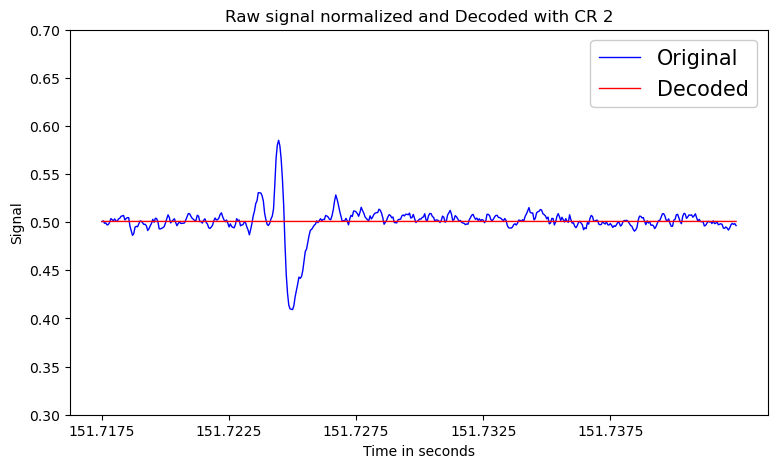

In [20]:
import matplotlib

%matplotlib inline

#matplotlib.use('webagg', force=True)
#plt.close('all')

matplotlib.rcParams['agg.path.chunksize'] = 1000

plt.figure(figsize=(9,5))
plt.title("Raw signal normalized and Decoded with CR 2")
plt.xlabel("Time in seconds")
plt.ylabel("Signal") #todo unit


figure_width = 500
offset = int(151.7425 * 20000 -  width/2)
#offset = int(339.68 * 20000 -  width/2)

#offset = regular_stimuli_interval * sampling_rate * 60 #offset incase we want to start at a different point
#offset = np.random.randint(0, x_train.shape[0] * neural_network_width - figure_width)

#to_show = data_scaler.inverse_transform(original_data_concat[int(offset-figure_width/2):int(offset + figure_width/2)])
#to_show_decoded = data_scaler.inverse_transform(decoded_data_concat[int(offset-figure_width/2):int(offset + figure_width/2)])

to_show = original_data_concat[int(offset-figure_width/2):int(offset + figure_width/2)]
to_show_decoded = decoded_data_concat[int(offset-figure_width/2):int(offset + figure_width/2)]


plt.plot(to_show, color="blue", label="Original", linewidth=1)
plt.plot(to_show_decoded, color="red", label="Decoded", linewidth=1)

#plt.axhline(y=0.45, color='g', linestyle='--', label="Threshold")
#plt.axhline(y=0.55, color='g', linestyle='--')
#plt.ylim(-5000,5000)

#first = False
#for i in range(0,100,5) : 
#    if i == 50 : 
#        continue
#    if not first : 
#        plt.axhline(y=i/100, color='g', linestyle='--', label="Threshold")
#        first = True
#    else : 
#        plt.axhline(y=i/100, color='g', linestyle='--')

#iterate over the spikes and plot the ones which are in the shown segment
#first = False
#for spike in all_spike_data_original[0.45][1] : 
#    if spike > offset - figure_width/2 and spike < offset + figure_width/2 : 
#        if not first :
#            plt.axvline(x=spike - offset + figure_width/2, color='black', linestyle='--', linewidth=1, label="Crossing threshold 0.45")
#            first = True
#        else : 
#            plt.axvline(x=spike - offset + figure_width/2, color='black', linestyle='--', linewidth=1)
#
#first = False
#for spike in all_spike_data_original[0.55][1] : 
#    if spike > offset - figure_width/2 and spike < offset + figure_width/2 : 
#        if not first : 
#            plt.axvline(x=spike - offset + figure_width/2, color='black', linestyle=':', linewidth=1, label="Crossing threshold 0.55")
#            first = True
#        else : 
#            plt.axvline(x=spike - offset + figure_width/2, color='black', linestyle=':', linewidth=1)
#


plt.ylim(0.3,0.7)

legend = plt.legend(loc="upper right", prop={'size': 15})
legend.get_frame().set_alpha(None)


#transform the xticks to seconds (divide by sampling_rate)
num_xticks = 5 # figure_width % num_xticks == 0
plt.xticks(np.arange(0, figure_width, figure_width//num_xticks), np.around(np.arange(float(offset-figure_width/2), float(figure_width/2+offset), float(figure_width/num_xticks))/sampling_rate, 4)) 

plt.ion()

plt.show()

In [21]:
#calculate mse between original test_data and decoded test_data
def calculate_mse(original_data, decoded_data) : 
    mse = 0
    for i in tqdm(range(len(original_data))) : 
        mse += (original_data[i] - decoded_data[i])**2
    return mse / len(original_data)

original_data_scaled_back = data_scaler.inverse_transform(np.reshape(original_data_concat, (original_data_concat.shape[0], 1))).flatten()
decoded_data_scaled_back = data_scaler.inverse_transform(np.reshape(decoded_data_concat, (decoded_data_concat.shape[0], 1))).flatten()

original_data_scaled_back = original_data_scaled_back.astype(np.float64)
decoded_data_scaled_back = decoded_data_scaled_back.astype(np.float64)


def calculate_snr(original_data, decoded_data) : 
    input_mean = np.mean(original_data)
    upper = 0 
    lower = 0 
    for i in tqdm(range(len(original_data))) :
        upper += (original_data[i] - input_mean)**2
        lower += (original_data[i] - decoded_data[i])**2
    return 10 * np.log10(upper/lower)



print("MSE: " + str(calculate_mse(original_data_scaled_back, decoded_data_scaled_back)))
print("SNR: " + str(calculate_snr(original_data_scaled_back, decoded_data_scaled_back)))

100%|██████████| 40031232/40031232 [00:11<00:00, 3453828.97it/s]


MSE: 14444.062712632627


100%|██████████| 40031232/40031232 [00:17<00:00, 2235378.78it/s]

SNR: -3.4094838738155476e-05
